In [ ]:
!pip install tqdm==4.60.0
from tqdm.notebook import tqdm

     |████████████████████████████████| 81kB 7.6MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.2MB/s 
     |████████████████████████████████| 3.3MB 40.1MB/s 
     |████████████████████████████████| 901kB 56.9MB/s 


In [ ]:
import os
import scipy.io as sio
import numpy as np
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.special import softmax
import cv2
from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW
from albumentations import *
from albumentations.pytorch import ToTensor
from torchvision import transforms, models

## Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##For Downloading the dataset uncomment the below cell and run it.

In [ ]:
#!pip install validators

In [ ]:
# import requests
# import validators
# from urllib.request import Request, urlopen
# from urllib.error import URLError, HTTPError

# File_data= np.loadtxt("/content/vis10cat (1).txt", dtype=str)
# pth = "/content/drive/MyDrive/Plot_Data/"   #Destination Folder where u want to save data



# def is_downloadable(url):
#   valid=validators. url(url)
#   if valid==False:
#     return False
#   req = Request(url)
#   try:
#     response = urlopen(req)
#   except HTTPError as e:
#     return False
#   except URLError as e:
#     return False
#   else:
#     return True

# for i in range(len(File_data)):
#   url = File_data[i][1]
#   try:
#     if (is_downloadable(url)):
#       try:
#         r = requests.get(url, allow_redirects=True)
#         if url.find('/'):
#           fname = url.rsplit('/', 1)[1]
#           fname = pth+File_data[i][0]+"$"+fname 
#           open(fname, 'wb').write(r.content)
#       except Exception as e:
#         print(e)
#   except Exception as e: 
#     print(e)


In [ ]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1024
seed_torch(seed)

In [ ]:
random_state = 97
batch_size=32
Dir = "/content/drive/MyDrive/Plot_Data/"

In [ ]:
import os
data_list = os.listdir(Dir)

In [ ]:
len(data_list)

2864

##Delete all Corrupted File

In [ ]:
# ##Deleting corrupted File

# for x in range(len(data_list)):
#   pth = Dir+data_list[x]
#   try:
#     imageObject = Image.open(pth)
#   except :
#     os.remove(pth)

##Spliting data into train and test dataset

In [ ]:
label = {"AreaGraph": 0, "BarGraph": 1, "LineGraph":2, "Map":3, "ParetoChart":4, "PieChart":5, "RadarPlot":6, "ScatterGraph":7, "Table":8, "VennDiagram":9} 

In [ ]:
rows, cols = (len(data_list), 2)

data=[]
for i in range(len(data_list)):
    col = []
    col.append(data_list[i])
    lab = data_list[i].split("$")[0]
    lab = label[lab]
    col.append(lab)
    data.append(col)

random.shuffle(data)
data = np.array(data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data[:,0], data[:,1], test_size = 0.2, random_state=47, stratify = data[:,1], shuffle=True)

In [ ]:
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

##Creating Custom dataloader for our task

In [ ]:
class Data(Dataset):
  def __init__(self,Dir, data_list, labels, train=True, test=False, valid=True):
    self.dir = Dir
    self.label = labels
    self.train = train
    self.valid = valid
    self.test = test
    self.data_list = data_list
    self.len = len(data_list)
    self.train_transform = Compose([HorizontalFlip(p=0.5),
                                  VerticalFlip(p=0.5),
                                  ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
                                  #
    # self.test_transform = Compose([HorizontalFlip(p=0.5),
    #                                    VerticalFlip(p=0.5),
    #                                    ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
    self.default_transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                         ToTensor()])
  def __len__(self):
    return self.len;
  def __getitem__(self,idx):
    pth = self.dir + self.data_list[idx]
    y= self.label[idx]
    y = torch.from_numpy(np.array(y))

    image = Image.open(pth)
    image = image.convert("RGB")
    image = np.asarray(image)
    image = cv2.resize(image, dsize=(64, 64))
    if self.train:
        image = self.train_transform(image=image)['image']
        image = self.default_transform(image=image)['image']
    # elif self.test:
    #     image = self.test_transform(image=image)['image']
    #     image = self.default_transform(image=image)['image']
    elif self.valid==True:
        image = self.default_transform(image=image)['image']
        
    if self.test==False:
        return image, y
    return image


In [ ]:
train_dataset = Data(Dir, X_train, y_train, train=True, test=False, valid =False)
validation_dataset = Data(Dir, X_valid, y_valid, train=False, test=False, valid=True)

In [ ]:
trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

validloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True
)
#dataloaders_dict ={'train':train_loader,'val':val_loader}

In [ ]:
!pip install efficientnet_pytorch


In [ ]:
import torch.optim as optim

from efficientnet_pytorch import EfficientNet
lr = 8e-04
BATCH_SIZE = 32
NUM_EPOCHS = 11
TRAIN_SIZE = y_train.shape[0]
VALID_SIZE = y_valid.shape[0]
dest_pth = "/content/drive/MyDrive/encoder/"  #path to save the model weight
MODEL_NAME = 'efficientnet-b5'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##Model

In [ ]:
model = EfficientNet.from_pretrained(MODEL_NAME)
#set_parameter_requires_grad(model, True)
num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,256,bias=True),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256,10, bias = True))

Loaded pretrained weights for efficientnet-b5


In [ ]:
#Print all trainable layer
params_to_update = model.parameters()
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 _conv_stem.weight
	 _bn0.weight
	 _bn0.bias
	 _blocks.0._depthwise_conv.weight
	 _blocks.0._bn1.weight
	 _blocks.0._bn1.bias
	 _blocks.0._se_reduce.weight
	 _blocks.0._se_reduce.bias
	 _blocks.0._se_expand.weight
	 _blocks.0._se_expand.bias
	 _blocks.0._project_conv.weight
	 _blocks.0._bn2.weight
	 _blocks.0._bn2.bias
	 _blocks.1._depthwise_conv.weight
	 _blocks.1._bn1.weight
	 _blocks.1._bn1.bias
	 _blocks.1._se_reduce.weight
	 _blocks.1._se_reduce.bias
	 _blocks.1._se_expand.weight
	 _blocks.1._se_expand.bias
	 _blocks.1._project_conv.weight
	 _blocks.1._bn2.weight
	 _blocks.1._bn2.bias
	 _blocks.2._depthwise_conv.weight
	 _blocks.2._bn1.weight
	 _blocks.2._bn1.bias
	 _blocks.2._se_reduce.weight
	 _blocks.2._se_reduce.bias
	 _blocks.2._se_expand.weight
	 _blocks.2._se_expand.bias
	 _blocks.2._project_conv.weight
	 _blocks.2._bn2.weight
	 _blocks.2._bn2.bias
	 _blocks.3._expand_conv.weight
	 _blocks.3._bn0.weight
	 _blocks.3._bn0.bias
	 _blocks.3._depthwise_conv.wei

In [ ]:

model.to(device)

optimizer = AdamW(model.parameters(), lr = lr, weight_decay = 1e-3)

num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def train_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Training')
    
    for _, (images, labels) in enumerate(loader):
        images, labels = images.float().to(device), labels.to(device)
        net.train()
        optimizer.zero_grad()
        predictions = net(images)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()*labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        pbar.update()
        
    accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/TRAIN_SIZE, accuracy

def valid_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            net.eval()
            predictions = net(images)
            loss = loss_fn(predictions, labels)
            
            running_loss += loss.item()*labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = accuracy_score(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat

In [ ]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = train_fn(model, loader = trainloader)
    vl, va, conf_mat = valid_fn(model, loader = validloader)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%11==0:
        path = dest_pth+'epoch' + str(epoch) + '.pt'
        torch.save(model.state_dict(), path)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    

Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0, Train loss: 2.2646457619252867, Val loss: 2.2067263596553035, Train acc: 0.1518987341772152, Val acc: 0.29668411867364747


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.7901987799490866, Val loss: 1.2613127934787078, Train acc: 0.4316892186817983, Val acc: 0.6352530541012217


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.1649393246507915, Val loss: 0.8511014731558622, Train acc: 0.6324749017896115, Val acc: 0.7469458987783595


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.9884877106811427, Val loss: 1.0399846747699624, Train acc: 0.6887821911828895, Val acc: 0.7137870855148342


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.879817602390912, Val loss: 0.9691508242805175, Train acc: 0.7306852902662593, Val acc: 0.7347294938917975


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.8029048022668157, Val loss: 0.9622989478951766, Train acc: 0.7634220864251419, Val acc: 0.774869109947644


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.6768881744143745, Val loss: 0.6941944358652591, Train acc: 0.7965953731994763, Val acc: 0.774869109947644


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.5854029938520068, Val loss: 0.6414799059872852, Train acc: 0.8271497162811, Val acc: 0.806282722513089


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.42323616091105054, Val loss: 0.5338251659383324, Train acc: 0.8681798341335661, Val acc: 0.8342059336823735


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9, Train loss: 0.3530576390530125, Val loss: 0.5427926775672673, Train acc: 0.890877346137058, Val acc: 0.8464223385689355


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10, Train loss: 0.34219477804713455, Val loss: 0.5453240073580184, Train acc: 0.8996071584460934, Val acc: 0.8464223385689355


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


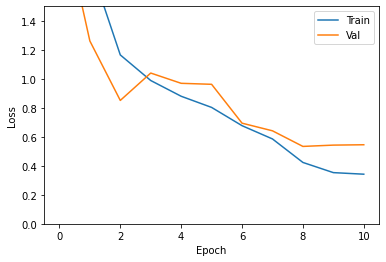

In [ ]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


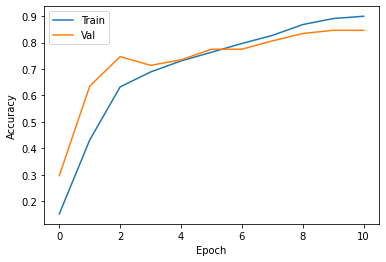

In [ ]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

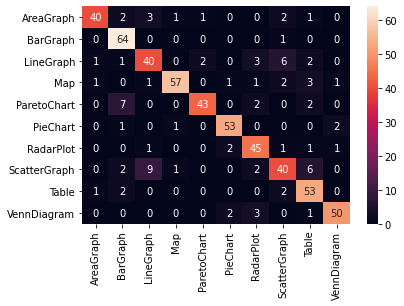

In [ ]:
labels = label
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)

#Run pretrained model From Here

In [3]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
import torch
from PIL import Image
import cv2
import torch.nn as nn
from albumentations import *
from albumentations.pytorch import ToTensor
MODEL_NAME = 'efficientnet-b5'

model = EfficientNet.from_pretrained(MODEL_NAME)
#set_parameter_requires_grad(model, True)
num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,256,bias=True),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(256,10, bias = True))

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=bb8acc4fcff2404f12589131c48475876521ac22d1027c126887aef5a0246123
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


In [4]:
model.load_state_dict(torch.load("/content/drive/MyDrive/encoder/epoch10.pt"))
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [5]:
import numpy as np
reverse_label_mapping = {0:"AreaGraph", 1:"BarGraph", 2:"LineGraph", 3:"Map", 4:"ParetoChart", 5:"PieChart", 6:"RadarPlot",7: "ScatterGraph", 8:"Table", 9:"VennDiagram"} 

In [6]:
def Predict(pth):
  image = Image.open(pth)
  image = image.convert("RGB")
  image = np.asarray(image)
  image = cv2.resize(image, dsize=(64, 64))
  transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                         ToTensor()])
  image = transform(image=image)['image']

  predict = model(image.resize(1,3,64,64).float())
  predict = np.argmax(predict.cpu().detach().numpy(), 1)
  predict = np.array(predict)
  label = reverse_label_mapping[predict[0]]
  return label


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


PieChart


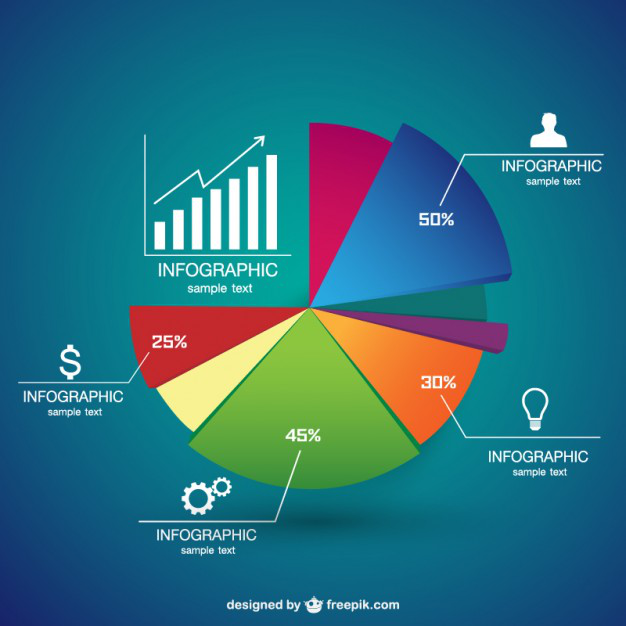

In [8]:
predicted_class = Predict("/content/test.jpg")
print(predicted_class)
image = Image.open("/content/test.jpg")
image


In [9]:
print(predicted_class)

PieChart
